In [1]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np

class totensor:
  def __call__(self, pic):
    return torch.from_numpy(np.array(pic)).to(torch.long)
# データ変換の定義
transform = transforms.Compose([
    #transforms.ToTensor(), # PIL ImageをTensorに変換 (0-1に正規化される)
    #transforms.Normalize((0.1307,), (0.3081,)) # MNISTの平均と標準偏差で正規化
    totensor()
])

# MNISTデータセットのダウンロード
train_dataset = datasets.MNIST(root='../data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='../data', train=False, download=True, transform=transform)

# データローダーの定義
batch_size = 1
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

torch.Size([28, 28]) tensor(9) tensor([  0,   0,   0,   0,   0,   0,   0,   0,   0, 157, 253, 253, 253, 253,
        217, 238, 253, 190,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0])


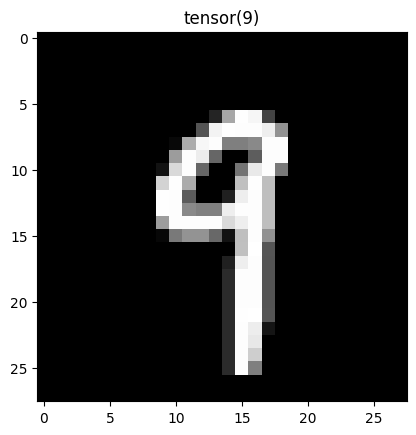

In [2]:
import torch
import matplotlib.pyplot as plt
for epoch, labels in train_loader:
  for batch,label in zip(epoch, labels):
    print(batch.shape, label, batch[14])
    plt.imshow(batch.squeeze(), cmap='gray')
    plt.title(label)
    break
  break

In [ ]:
import torch.optim as optim
from tqdm.notebook import tqdm
from TransformerModel import TransformerModel

seq_len = 28*28  # シーケンスの長さ
vocab_size = 256
dim = 128     # 特徴量の次元
div = 128
N = 64
layer = 6
learning_rate = 0.001
epochs = 1    # 短いエポック数で動作確認
device = 'cuda'
is_emb, is_ssm, is_ffn = True, True, False

# 1. モデルのインスタンス化
model = Module(vocab_size=vocab_size, dim=dim, N=N, div=div, layer=layer).to(device)
#model = TransformerModel(vocab_size, seq_len, dim, layer).to(device)
model.load_state_dict(torch.load('../module/StateSpaceModel_128.pth'))

idx_in = 400
idx_out = 0
model.eval()
with torch.no_grad():
    for test, labels in tqdm(test_loader):
        # 順伝播
        #print(batch.shape)
        test = test.view(test.shape[0], -1).to(device)
        print(f'test:{test[:,:idx_in].shape}')
        output = model(test[:,:idx_in], cnn=False, is_emb=is_emb, is_ssm=is_ssm, is_ffn=is_ffn)
        print(f'output:{output.shape}')
        rnn = [output[:,-1][:, None]]
        for _ in range(783 - idx_in):
            #print(f'rnn:{rnn[-1].shape}')
            out = model(torch.argmax(rnn[-1], dim=-1), cnn=False, is_emb=is_emb, is_ssm=is_ssm, is_ffn=is_ffn)
            #print(f'out:{out[:,-1,:].shape}')
            rnn.append(out[:,-1,:].unsqueeze(1))
        #print(len(rnn))
        rnn = torch.cat(rnn, dim=1)
        print(f'cat:{rnn.shape}')
        output = torch.cat([output, rnn[:, 1:, :]], dim=1)
        print(f'output:{output.shape}')
        img = torch.cat([test[:,:idx_out+1], torch.argmax(output[:,idx_out:], dim=-1)], dim=1).to('cpu')
        print(img.shape)
        img = img.reshape(batch_size, 28, 28)
        #print(img[0].shape)
        plt.imshow(img[0].detach().numpy(), cmap='gray')
        break